In [1]:
import os
from pathlib import Path
import shutil
import datetime
import json
import numpy as np
import pymupdf
import cv2
import torch
import imutils
from imutils.contours import sort_contours
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
from tkinter import filedialog
from tkinter import Tk
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append('../src')
from segmentation import segment
from text_removal import remove_text

# Paths
PDF_FOLDER = "../data/__pages"
UNCLASSIFIED_FOLDER = "../data/__unclassified"
DATASET_FOLDER = "../data/dataset"
MODEL_PATH = "../models/current_model.pth"
CLASSES_PATH = "../models/classes.json"

# Create folders if they don't exist
os.makedirs(PDF_FOLDER, exist_ok=True)
os.makedirs(UNCLASSIFIED_FOLDER, exist_ok=True)


## PROCESS PDF

In [15]:
def process_pdf(pdf_path, page_range, pdf_folder, contour_folder, target_size=224):
    doc = pymupdf.open(pdf_path)
    total = 0
    for page_num in page_range:
        if page_num < 0 or page_num >= len(doc):
            print(f"Page {page_num} is out of range. Skipping.")
            continue
        page = doc.load_page(page_num)
        pix = page.get_pixmap(dpi=300)  # High DPI for quality
        filename = Path(pdf_path).stem
        img_path = os.path.join(pdf_folder, f"{filename}_p{page_num+1:04}.png")
        pix.save(img_path)

        # Resize the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        segmentation = segment(img)
        img = remove_text(img, segmentation)
        
        blurred = cv2.GaussianBlur(img, (5, 5), 0);

        edged = cv2.Canny(blurred, 30, 150)

        contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)     

        contours = imutils.grab_contours(contours)

        for contour in contours:
            # Get the bounding box for each contour
            x, y, w, h = cv2.boundingRect(contour)
            (cx,cy),r = cv2.minEnclosingCircle(contour)
            cx = int(cx)
            cy = int(cy)
            r = int(r)

            # Filter out very small contours
            if w < 5:
                continue

            # Crop the region of interest (ROI) from the original image
            roi = img[y:y+h, x:x+w]

            (tH, tW) = img.shape

            scale = target_size / max(h, w)
            new_w = int(w * scale)
            new_h = int(h * scale)

            resized = cv2.resize(roi, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

            (tH, tW) = resized.shape
            dX = int(max(0, target_size - tW) / 2.0)
            dY = int(max(0, target_size - tH) / 2.0)
            # pad the image and force dimensions
            padded = cv2.copyMakeBorder(resized, top=dY, bottom=dY,
            	left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
            	value=(0, 0, 0))
            padded = cv2.resize(padded, (target_size, target_size), interpolation=cv2.INTER_CUBIC)
            
            img_path = os.path.join(contour_folder, f"{filename}_p{page_num+1:04}_x{x:04}_y{y:04}_w{w:04}_h{h:04}_cx{cx:04}_cy{cy:04}_r{r:04}.png")
            cv2.imwrite(img_path, padded)
            
            total = total + 1
    
    return total
    
pdf_output = widgets.Output()

def on_pick_file_button_click(_):
    with pdf_output:
        root = Tk()
        root.withdraw()  # Hide Tkinter root window
        root.call('wm', 'attributes', '.', '-topmost', True)
        selected_file.value = filedialog.askopenfilename(title="Select a PDF File", filetypes=[("PDF Files", "*.pdf")], parent=root)
        root.destroy

pick_file_button = widgets.Button(description="Choose File")
pick_file_button.on_click(on_pick_file_button_click)


# Interactive widgets for page range input
start_page = widgets.IntText(value=1, description="Start Page:", step=1)
end_page = widgets.IntText(value=5, description="End Page:", step=1)
pdf_folder = widgets.Text(value=PDF_FOLDER, description="PDF Output Folder:")
selected_file = widgets.Text(value='', description="Selected File:")
contour_folder = widgets.Text(value=UNCLASSIFIED_FOLDER, description="Contours Output Folder:")

def on_button_click(_):
    with pdf_output:
         # Get user input for page range
         start = start_page.value - 1  # Convert to 0-based index
         end = end_page.value - 1     # Convert to 0-based index
         page_range = list(range(start, end + 1))
        
         # Run contour extraction
         print("Extracting...")
         total = process_pdf(selected_file.value, page_range, pdf_folder.value, contour_folder.value)
         print(f"Done. Extracted {total} contours")

# Button to trigger the extraction
extract_button = widgets.Button(description="Extract Contours")
extract_button.on_click(on_button_click)

# Display widgets
display(widgets.HBox([pick_file_button, selected_file]), start_page, end_page, pdf_folder, contour_folder, extract_button, pdf_output)

IntText(value=1, description='Start Page:')

IntText(value=5, description='End Page:')

Text(value='../data/__pages', description='PDF Output Folder:')

Text(value='../data/__unclassified', description='Contours Output Folder:')

Button(description='Extract Contours', style=ButtonStyle())

Output()

## Predict

In [16]:
def predict_images(model, classes, image_folder, progress):
    progress.value = 0
    
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    
    predictions = []
    model.eval()

    files = os.listdir(image_folder)

    progress.max = len(files)
    
    for img_name in files:
        img_path = os.path.join(image_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        
        tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            output = model(tensor)
        
        probabilities = nn.functional.softmax(output[0], dim=0)
        class_id = torch.argmax(probabilities).item()
        confidence = probabilities[class_id]

        predictions.append({
            "filepath": img_path,
            "prediction": classes[class_id],
            "confidence": confidence
        })

        progress.value = progress.value + 1
    
    return predictions

# Set up the progress widget
predict_progress = widgets.IntProgress(
    value=0,
    min=0,
    max=10,
    description='Progress:',
    bar_style='info',
    style={'bar_color': 'blue'},
    orientation='horizontal'
)

predictions = None

def on_predict_click(_):
    global predictions
    with predict_output:
    # Load the model
        with open(CLASSES_PATH) as f:
            classes = json.load(f)
    
        model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_features = model.last_channel  # Get the size of the last layer
        model.classifier[1] = nn.Linear(num_features, len(classes))  # Replace classifier
        model.load_state_dict(torch.load(MODEL_PATH))
    
        predictions = predict_images(model, classes, folder_to_predict_widget.value, predict_progress)
        print(f"{len(predictions)} predictions created for {folder_to_predict_widget.value}.")

folder_to_predict_widget = widgets.Text(value=UNCLASSIFIED_FOLDER, description="Image Folder:")
predict_button = widgets.Button(description="Go")
predict_button.on_click(on_predict_click)
predict_output = widgets.Output()

display(widgets.HBox([folder_to_predict_widget, predict_button]), predict_progress, predict_output)

IntProgress(value=0, bar_style='info', description='Progress:', max=10, style=ProgressStyle(bar_color='blue'))

Output()

## Convert Predictions to Dataset

In [17]:
#session = fo.launch_app(port=5151, auto=False)

# Load predictions into FiftyOne
samples = []
for pred in predictions:
    sample = fo.Sample(filepath=pred["filepath"])
    sample["prediction"] = fo.Classification(label=pred["prediction"], confidence=pred["confidence"])
    samples.append(sample)

# Create or load a FiftyOne dataset
now = datetime.datetime.now()
datetime_string = now.strftime("%Y%m%d%H%M%S")

dataset_name = f"predictions_{datetime_string}"

dataset = fo.Dataset(dataset_name)
dataset.add_samples(samples)
dataset.persistent = True
dataset.save()

print(f"Created dataset {dataset_name}")

#session.dataset = dataset

# fob.compute_similarity(
#     dataset,
#     model="clip-vit-base32-torch",
#     brain_key="img_sim",
# )

 100% |███████████████| 3029/3029 [1.2s elapsed, 0s remaining, 2.5K samples/s]         
Created dataset predictions_20241215140721


In [66]:
session = fo.launch_app(port=5151)


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds



## Update Dataset

In [32]:
def render_update_dataset_cell():
    def update_dataset(dataset, dataset_folder):
        count = 0
        for sample in dataset:
            if sample.tags:
                label = sample.tags[0]
                class_folder = os.path.join(dataset_folder, label)
                os.makedirs(class_folder, exist_ok=True)
    
                new_path = os.path.join(class_folder, os.path.basename(sample.filepath))
    
                if not os.path.exists(new_path):
                    shutil.copy(sample.filepath, new_path)
                    count = count + 1
                    
        print(f"Added {count} files to {dataset_folder}")
    
    output = widgets.Output()
    
    def add(_):
        with output:
            import fiftyone as fo
            dataset = fo.load_dataset(dataset_text_widget.value)
            update_dataset(fo.load_dataset(dataset_text_widget.value), DATASET_FOLDER)
    
    add_button = widgets.Button(description="Add")
    add_button.on_click(add)

    dataset_text_widget = widgets.Text(value=dataset_name, description="Dataset:")

    display(widgets.HBox([dataset_text_widget, add_button]), output)

render_update_dataset_cell()

Output()

## Add tag to selected samples

In [42]:
add_tag_output = widgets.Output()

def add_tag(_):
    with add_tag_output:
        count = 0
        for sample in session.selected:
            session.dataset[sample].tags.append(tag_widget.value)
            count = count + 1
        print(f"Added {count} tags")

tag_widget = widgets.Text(value='', description="Tag")
add_tag_button = widgets.Button(description="Add")
add_tag_button.on_click(add_tag)
display(widgets.HBox([tag_widget, add_tag_button]), add_tag_output)

Output()

## Train Model

In [ ]:
def train_model(dataset_folder, model, epochs=10):
    # Implement training loop here based on your dataset structure
    pass

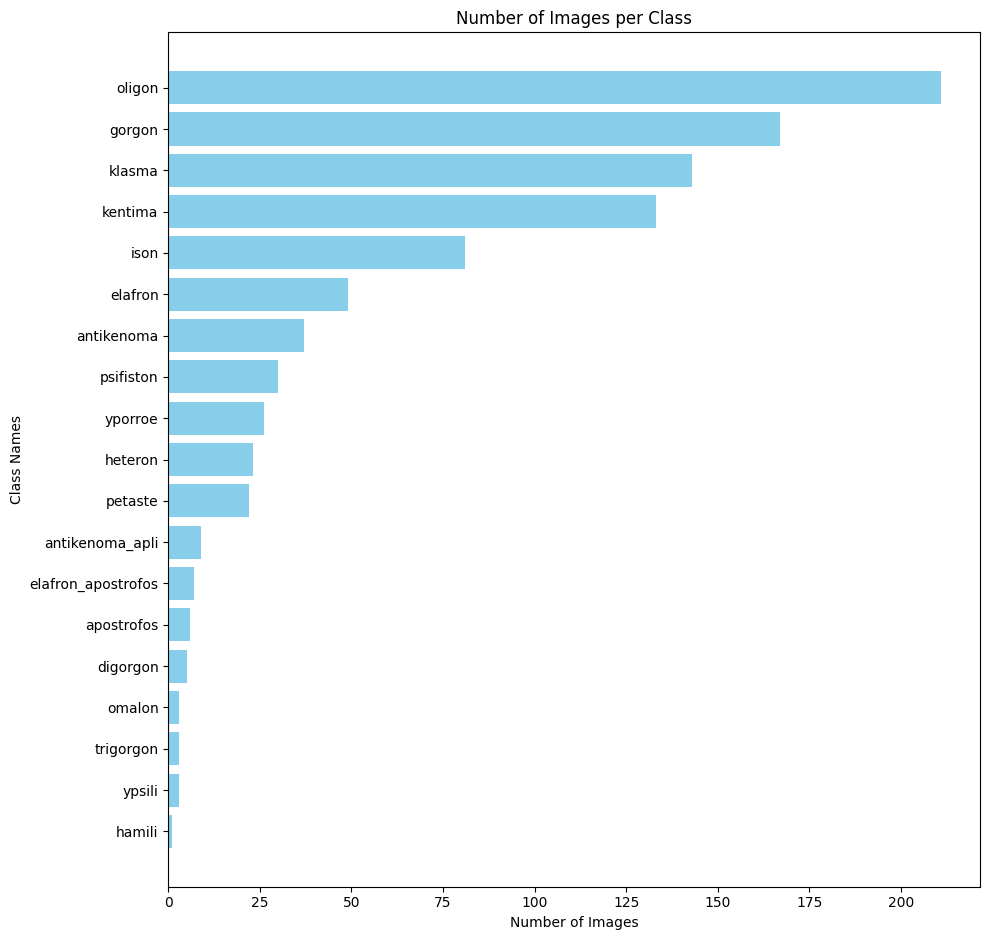

In [11]:
class_counts = {}

for class_name in os.listdir(DATASET_FOLDER):
    class_path = os.path.join(DATASET_FOLDER, class_name)
    if os.path.isdir(class_path):  # Ensure it's a directory
        image_count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        class_counts[class_name] = image_count

# Sort classes by the number of images
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
class_names, image_counts = zip(*sorted_classes)

# Plot the horizontal bar graph
plt.figure(figsize=(10, len(class_names) * 0.5))
plt.barh(class_names, image_counts, color="skyblue")
plt.xlabel("Number of Images")
plt.ylabel("Class Names")
plt.title("Number of Images per Class")
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()